<a href="https://colab.research.google.com/github/MLandML/MLandML/blob/learning_projects/Basic_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch,pdb #pdb debugger
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms #we can transform the images in the training data in any way
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm #library for creating progress bars
import matplotlib.pyplot as plt

In [2]:
#visualization function
def show(tensor,ch=1,size=(28,28),num=16): #tensor: 128x784
  data = tensor.detach().cpu().view(-1,ch,*size)  #detach:detaching from all gradient computation #view: reshape,128x1x28x28
  grid = make_grid(data[:num],nrow=4).permute(1,2,0) # 1x28x28 = 28x28x1
  plt.imshow(grid)
  plt.show()

In [3]:
from torchvision.transforms.transforms import ToTensor
#main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 100
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64 #dim of input of generator (noise)
lr = 0.0001
loss = nn.BCEWithLogitsLoss()

device = 'cuda' #nvidia's gpu

dataloader = DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),shuffle=True,batch_size=128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
#generator
def genblock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self,z_dim=64,i_dim=784,h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genblock(z_dim,h_dim), #64 to 128
        genblock(h_dim,h_dim*2), #128 to 256
        genblock(h_dim*2,h_dim*4), #256,512
        genblock(h_dim*4,h_dim*8), #512,1024
        nn.Linear(h_dim*8,i_dim) #1024,784
    )

  def forward(self,noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number,z_dim).to(device)

In [5]:
#discriminator
def discblock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self,i_dim=784,h_dim=256):
    super().__init__()
    self.disc = nn.Sequential(
        discblock(i_dim,h_dim*4), #784,1024
        discblock(h_dim*4,h_dim*2),
        discblock(h_dim*2,h_dim),
        nn.Linear(h_dim,1)
    )

  def forward(self,image):
    return self.disc(image)

In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr)

In [7]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
  )
)

In [8]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([0, 7, 3, 1, 7, 2, 9, 4, 7, 0])


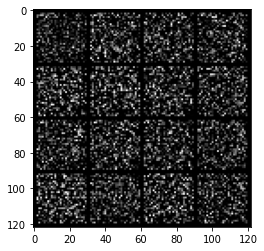

In [10]:
x,y = next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])

noise = gen_noise(128,z_dim)
fake = gen(noise)
show(fake)